In [2]:
!pip install librosa

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 38.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 49.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   ---------- ----------------------------- 7.6/28.1 MB 36.2 MB/s eta 0:00:01
   --------------------- ------------------ 14.9/28.1 MB 36.1 MB/s eta 0:00:01
   ------------------------------ --------- 21.5/28.1 MB 34.8 MB/s eta 0:00:01
   ---------------------------------------  28.0/28.1 MB 34.2 MB/s eta 0:00:01
   ---------------------------------------- 28.1/28.1 MB 31.8 MB/s eta 0:00:00


# DTW

In [ ]:
import librosa
import numpy as np


# DTW 계산 함수
def calculate_weighted_dtw_similarity(file1, file2):
    y1, sr1 = librosa.load(file1, sr=16000)
    y2, sr2 = librosa.load(file2, sr=16000)

    # MFCC 추출
    mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=13)
    mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=13)

    # 가중치 설정 및 정규화
    weights = np.array([2.0, 1.8, 1.6] + [1] * 10)
    weights = weights / weights.sum()

    # 가중치 적용
    mfcc1_weighted = mfcc1 * weights[:, np.newaxis]
    mfcc2_weighted = mfcc2 * weights[:, np.newaxis]

    # DTW 거리 계산
    dtw_distance, _ = librosa.sequence.dtw(
        X=mfcc1_weighted, Y=mfcc2_weighted, metric="euclidean"
    )

    # 거리 정규화
    normalized_distance = dtw_distance.mean() / min(len(mfcc1.T), len(mfcc2.T))

    # 유사도 점수 계산
    similarity_score = max(0, 100 - (normalized_distance * 10))
    return similarity_score


# 유사도 점수 계산 예시
dtw_score = calculate_weighted_dtw_similarity(
    "./test_data/eraser_a.wav", "./test_data/eraser_scale.wav"
)
print(f"DTW Similarity Score: {dtw_score:.2f}")

DTW Similarity Score: 0.00


# 포먼트 주파수 평균

In [1]:
import parselmouth
from parselmouth.praat import call
import numpy as np


# 포먼트 주파수 평균 추출 함수
def get_formants(file_path):
    snd = parselmouth.Sound(file_path)
    formant = snd.to_formant_burg()
    f1 = []
    f2 = []
    for t in formant.ts():
        f1.append(formant.get_value_at_time(1, t))
        f2.append(formant.get_value_at_time(2, t))
    return np.nanmean(f1), np.nanmean(f2)  # 평균 값 반환, NaN 값 무시


# 원어민과 학생 포먼트 추출
f1_native, f2_native = get_formants("./test_data/eraser_a.wav")
f1_student, f2_student = get_formants("./test_data/eraser_a.wav")

# 포먼트 차이 계산
f1_diff = abs(f1_native - f1_student)
f2_diff = abs(f2_native - f2_student)
print(f"F1 Difference: {f1_diff}")
print(f"F2 Difference: {f2_diff}")

# 최대 차이 값을 조정하여 정규화
max_diff = 1000  # 차이를 더 큰 값으로 설정하여 정규화

# 점수 계산
formant_score = max(0, 100 - ((f1_diff + f2_diff) / (2 * max_diff)) * 100)

print(f"Formant Score: {formant_score:.2f}")

PraatError: Cannot open file “c:\Users\user\Desktop\eng-word\utils\PronunciationChecker\.\test_data\eraser_a.wav”.
Sound not read from sound file “c:\Users\user\Desktop\eng-word\utils\PronunciationChecker\.\test_data\eraser_a.wav”.

In [2]:
import wave
import json
from vosk import Model, KaldiRecognizer
from difflib import SequenceMatcher

# Vosk 모델 설정
model = Model("C:/Users/user/Desktop/eng-word/utils/PronunciationChecker/PC_Pipeline/model/vosk-model-en-us-0.22")


def transcribe_audio_vosk(audio_path):
    wf = wave.open(audio_path, "rb")
    recognizer = KaldiRecognizer(model, wf.getframerate())

    result_text = ""
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if recognizer.AcceptWaveform(data):
            result = json.loads(recognizer.Result())
            result_text += result.get("text", "") + " "

    final_result = json.loads(recognizer.FinalResult())
    result_text += final_result.get("text", "")
    return result_text


def evaluate_pronunciation(audio_path, expected_word):
    # 음성을 텍스트로 변환
    recognized_text = transcribe_audio_vosk(audio_path)
    print(f"Recognized Text: {recognized_text}")

    # 예상 단어와 인식된 텍스트의 유사도 계산
    similarity = SequenceMatcher(
        None, expected_word.lower(), recognized_text.lower()
    ).ratio()
    phoneme_score = similarity * 100  # 점수를 백분율로 환산
    print(f"Expected Word: {expected_word}")
    print(f"Phoneme-Level Accuracy Score: {phoneme_score:.2f}%")
    return phoneme_score


# 예제 사용법
audio_path = "./test_data/eraser_scale.wav"  # 음성 파일 경로를 설정하세요
expected_word = "eraser"  # 예상 발음 단어 설정
evaluate_pronunciation(audio_path, expected_word)

FileNotFoundError: [Errno 2] No such file or directory: './test_data/eraser_scale.wav'

# 평가

In [ ]:
def calculate_overall_score(formant_score, phoneme_score):
    # 가중치 설정
    formant_weight = 0.4
    phoneme_weight = 0.6

    # 종합 점수 계산
    overall_score = formant_score * formant_weight + phoneme_score * phoneme_weight
    return overall_score


# 예시 점수
formant_score = 85.0  # 예시 Formant Score
phoneme_score = 90.0  # 예시 Phoneme-Level Accuracy Score

# 종합 점수 계산
overall_score = calculate_overall_score(formant_score, phoneme_score)
print(f"Overall Pronunciation Score: {overall_score:.2f}")

# 시각화

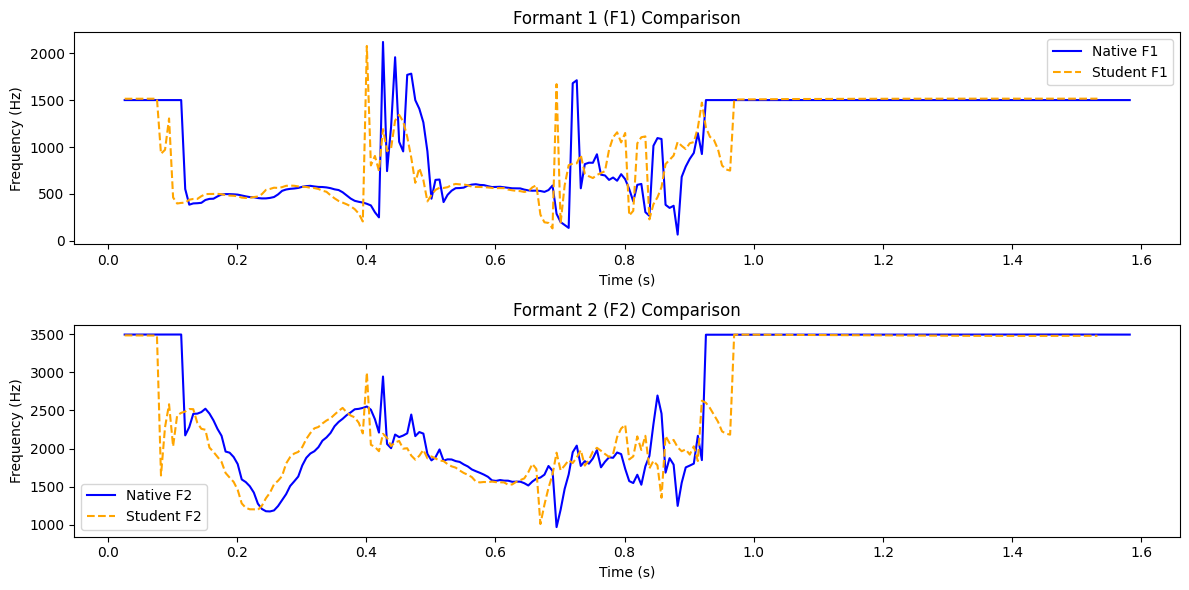

In [ ]:
import parselmouth
from parselmouth.praat import call
import matplotlib.pyplot as plt
import numpy as np


# 포먼트 주파수 추출 함수
def extract_formants(file_path):
    try:
        snd = parselmouth.Sound(file_path)
        formant = snd.to_formant_burg()
        times = formant.ts()  # 시간 축

        # F1, F2 포먼트 추출, None 값은 0으로 처리
        f1 = [
            (
                formant.get_value_at_time(1, t)
                if formant.get_value_at_time(1, t) is not None
                else 0
            )
            for t in times
        ]
        f2 = [
            (
                formant.get_value_at_time(2, t)
                if formant.get_value_at_time(2, t) is not None
                else 0
            )
            for t in times
        ]

        return times, f1, f2
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return [], [], []


# 원어민과 학생 발음에서 F1, F2 추출
times_native, f1_native, f2_native = extract_formants("./test_data/eraser_a.wav")
times_student, f1_student, f2_student = extract_formants("./test_data/eraser_b.mp3")

# 시각화
plt.figure(figsize=(12, 6))

# F1 시각화
plt.subplot(2, 1, 1)
if len(times_native) > 0 and len(f1_native) > 0:  # 데이터가 있을 때만 플롯
    plt.plot(times_native, f1_native, label="Native F1", color="blue")
if len(times_student) > 0 and len(f1_student) > 0:
    plt.plot(
        times_student, f1_student, label="Student F1", color="orange", linestyle="--"
    )
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Formant 1 (F1) Comparison")
plt.legend()

# F2 시각화
plt.subplot(2, 1, 2)
if len(times_native) > 0 and len(f2_native) > 0:
    plt.plot(times_native, f2_native, label="Native F2", color="blue")
if len(times_student) > 0 and len(f2_student) > 0:
    plt.plot(
        times_student, f2_student, label="Student F2", color="orange", linestyle="--"
    )
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Formant 2 (F2) Comparison")
plt.legend()

plt.tight_layout()
plt.show()

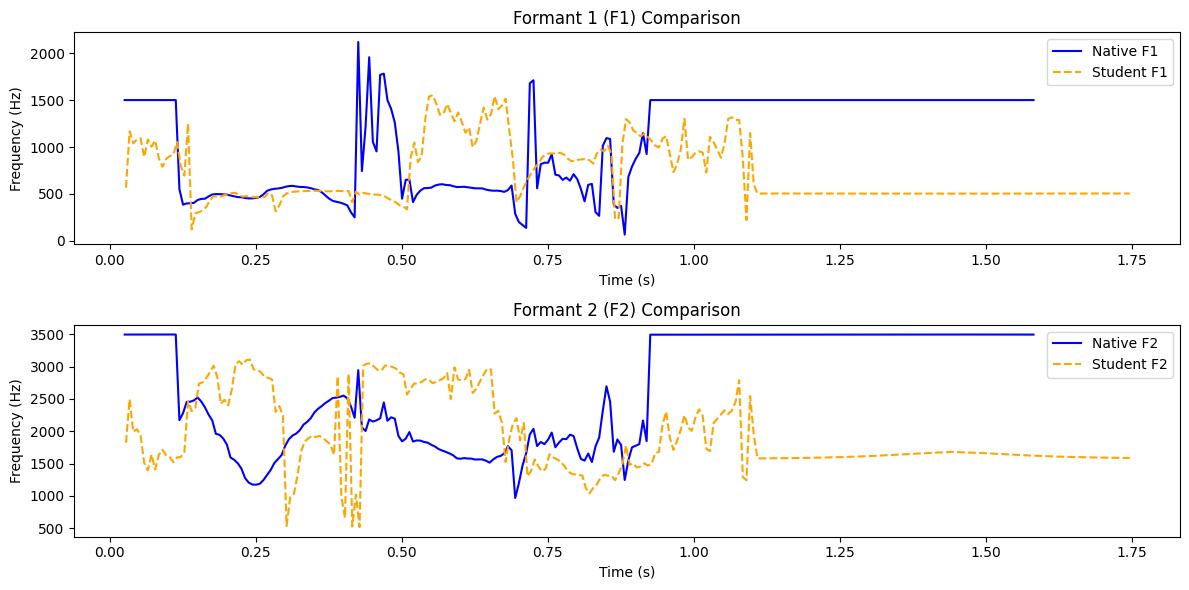

In [ ]:
import parselmouth
from parselmouth.praat import call
import matplotlib.pyplot as plt
import numpy as np


# 포먼트 주파수 추출 함수
def extract_formants(file_path):
    try:
        snd = parselmouth.Sound(file_path)
        formant = snd.to_formant_burg()
        times = formant.ts()  # 시간 축

        # F1, F2 포먼트 추출, None 값은 0으로 처리
        f1 = [
            (
                formant.get_value_at_time(1, t)
                if formant.get_value_at_time(1, t) is not None
                else 0
            )
            for t in times
        ]
        f2 = [
            (
                formant.get_value_at_time(2, t)
                if formant.get_value_at_time(2, t) is not None
                else 0
            )
            for t in times
        ]

        return times, f1, f2
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return [], [], []


# 원어민과 학생 발음에서 F1, F2 추출
times_native, f1_native, f2_native = extract_formants("./test_data/eraser_a.wav")
times_student, f1_student, f2_student = extract_formants("./test_data/eraser_scale.wav")

# 시각화
plt.figure(figsize=(12, 6))

# F1 시각화
plt.subplot(2, 1, 1)
if len(times_native) > 0 and len(f1_native) > 0:  # 데이터가 있을 때만 플롯
    plt.plot(times_native, f1_native, label="Native F1", color="blue")
if len(times_student) > 0 and len(f1_student) > 0:
    plt.plot(
        times_student, f1_student, label="Student F1", color="orange", linestyle="--"
    )
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Formant 1 (F1) Comparison")
plt.legend()

# F2 시각화
plt.subplot(2, 1, 2)
if len(times_native) > 0 and len(f2_native) > 0:
    plt.plot(times_native, f2_native, label="Native F2", color="blue")
if len(times_student) > 0 and len(f2_student) > 0:
    plt.plot(
        times_student, f2_student, label="Student F2", color="orange", linestyle="--"
    )
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Formant 2 (F2) Comparison")
plt.legend()

plt.tight_layout()
plt.show()